### Environment Setup and Text Cleaning

In [1]:
# Environment Setup and Package Imports

import nltk
import re
import string
import os
import json
import pickle
import pandas as pd
from datasets import load_dataset

# Download necessary NLTK resources
nltk.download('gutenberg')
nltk.download('brown')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /home/chockalingamveerap.n/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     /home/chockalingamveerap.n/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/chockalingamveerap.n/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/chockalingamveerap.n/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/chockalingamveerap.n/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Utility functions for text cleaning and caching

def clean_text(text, remove_punctuation=False):
    # Convert to lowercase and remove newlines and extra spaces
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    if remove_punctuation:
        # Remove all punctuation if specified
        text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def load_or_cache(filename, loader_func, save_format='json'):
    """
    Checks if cached file exists. If so, loads it.
    Otherwise, calls `loader_func` to generate data, caches it, and returns it.
    Supports both JSON and pickle formats.
    """
    if os.path.exists(filename):
        print(f"Loading from cache: {filename}")
        with open(filename, 'r' if save_format == 'json' else 'rb') as f:
            return json.load(f) if save_format == 'json' else pickle.load(f)
    else:
        print(f"Processing and caching: {filename}")
        data = loader_func()
        with open(filename, 'w' if save_format == 'json' else 'wb') as f:
            (json.dump(data, f) if save_format == 'json' else pickle.dump(data, f))
        return data

In [3]:
# Load NLTK and HuggingFace datasets

def load_gutenberg_corpus():
    from nltk.corpus import gutenberg
    return {fid: clean_text(gutenberg.raw(fid)) for fid in gutenberg.fileids()}

def load_brown_corpus():
    from nltk.corpus import brown
    return {
        cat: clean_text(" ".join(brown.words(categories=cat)))
        for cat in brown.categories()
    }

def load_wikitext():
    dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train")
    return [clean_text(example['text']) for example in dataset if example['text'].strip()]

# Load with caching
gutenberg_texts = load_or_cache("gutenberg_cleaned.json", load_gutenberg_corpus)
brown_texts = load_or_cache("brown_cleaned.json", load_brown_corpus)
wikitext_texts = load_or_cache("wikitext_cleaned.pkl", load_wikitext, save_format='pkl')


Loading from cache: gutenberg_cleaned.json
Loading from cache: brown_cleaned.json
Loading from cache: wikitext_cleaned.pkl


In [4]:
# Preview sample outputs from each corpus

print("Gutenberg Sample:")
for fileid, text in list(gutenberg_texts.items())[:1]:
    print(f"File: {fileid}")
    print(text[:500])
    break

print("\nBrown Corpus Sample:")
for category, text in list(brown_texts.items())[:1]:
    print(f"Category: {category}")
    print(text[:500])
    break

print("\nWikiText-103 Sample:")
print(wikitext_texts[0][:500])

Gutenberg Sample:
File: austen-emma.txt
[emma by jane austen 1816] volume i chapter i emma woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her. she was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period. her mother had died too lon

Brown Corpus Sample:
Category: adventure
dan morgan told himself he would forget ann turner . he was well rid of her . he certainly didn't want a wife who was fickle as ann . if he had married her , he'd have been asking for trouble . but all of this was rationalization . sometimes he woke up in the middle of the night thinking of ann , and then could not get back to sleep . his plans and dreams had revolved around her so much and for so long that now he

### Annotation Using GPT-3.5 Turbo

In [5]:
# Load OpenAI API key securely from .env file

from dotenv import load_dotenv
load_dotenv()

import openai
import os

openai.api_key = os.getenv("OPENAI_API_KEY")

In [6]:
# Verify OpenAI connection is working

from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def check_connection():
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Connection test."},
                {"role": "user", "content": "Hello!"}
            ],
            max_tokens=10
        )
        print("Connection successful!")
        print("Response:", response.choices[0].message.content)
    except Exception as e:
        print("Connection failed:", e)

check_connection()

Connection successful!
Response: Hello! How can I assist you today?


In [7]:
# Annotate passages using GPT-3.5 Turbo with original prompt format

import time
import traceback

def clean_json_response(content):
    """
    Cleans model output by removing markdown formatting like ```json ... ```
    """
    content = content.strip()
    if content.startswith("```json"):
        content = content[7:]
    if content.endswith("```"):
        content = content[:-3]
    return content.strip()

def annotate_passage(passage, max_words=100, retry_count=3):
    """
    Annotates a passage using the OpenAI API (GPT-3.5 Turbo).
    Identifies up to 10 contextually difficult words with definitions.
    Includes retry logic and passage splitting if too long.
    """
    if len(passage.split()) < 8:
        print("Passage too short; skipping.")
        return {"annotations": []}

    prompt = (
        'You are an expert in language comprehension. Given a passage, identify up to 10 contextually difficult or '
        'uncommon words (those that might be challenging at sight for an adult) and provide clear, concise definitions '
        'for each. Structure your response in JSON format using the following template:\n\n'
        '{"annotations": [{"word": "example", "definition": "concise definition"}]}\n\n'
        "Passage:\n" + passage
    )

    for attempt in range(retry_count):
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a language expert that provides clear and concise definitions."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.3,
                max_tokens=400
            )
            content = clean_json_response(response.choices[0].message.content)
            return json.loads(content)

        except Exception as e:
            if "context" in str(e).lower() or "tokens" in str(e).lower():
                # If passage is too long, split and try again with smaller segments
                print("Passage too long. Splitting and retrying...")
                if max_words <= 20:
                    return {"annotations": []}
                segments = [" ".join(passage.split()[i:i + max_words]) for i in range(0, len(passage.split()), max_words)]
                combined = {"annotations": []}
                for seg in segments:
                    ann = annotate_passage(seg, max_words=max_words // 2, retry_count=retry_count)
                    combined["annotations"].extend(ann.get("annotations", []))
                return combined

            elif "rate limit" in str(e).lower() or "connection" in str(e).lower():
                # Retry on transient issues like rate limit or network errors
                wait = 5 * (attempt + 1)
                print(f"Retrying after {wait} seconds...")
                time.sleep(wait)
            else:
                # Log any unexpected error and exit
                print("Unexpected error:", e)
                traceback.print_exc()
                return {"annotations": []}

    print("Failed after retries for:", passage[:100])
    return {"annotations": []}

In [8]:
# Pick the first passage and inspect its structure
first_passage = list(gutenberg_texts.values())[0]  # or brown_texts / wikitext_texts if you prefer

# Tokenize into sentences
sentences     = nltk.sent_tokenize(first_passage)
num_sentences = len(sentences)
num_words     = len(first_passage.split())

print("First Passage Analysis:")
print(f"- Number of sentences: {num_sentences}")
print(f"- Number of words:     {num_words}")
print("\nFirst 5 sentences:\n")
for sentence in sentences[:5]:
    print(".", sentence)

First Passage Analysis:
- Number of sentences: 7448
- Number of words:     158167

First 5 sentences:

. [emma by jane austen 1816] volume i chapter i emma woodhouse, handsome, clever, and rich, with a comfortable home and happy disposition, seemed to unite some of the best blessings of existence; and had lived nearly twenty-one years in the world with very little to distress or vex her.
. she was the youngest of the two daughters of a most affectionate, indulgent father; and had, in consequence of her sister's marriage, been mistress of his house from a very early period.
. her mother had died too long ago for her to have more than an indistinct remembrance of her caresses; and her place had been supplied by an excellent woman as governess, who had fallen little short of a mother in affection.
. sixteen years had miss taylor been in mr. woodhouse's family, less as a governess than a friend, very fond of both daughters, but particularly of emma.
. between _them_ it was more the intimac

In [9]:
# Generate dataset by sampling and annotating passages

import random
import nltk

NUM_PASSAGES_TO_ANNOTATE = 2000    # Total passages to draw from all sources
SAMPLES_PER_PASSAGE      = 3       # Number of samples to generate per passage
NUM_SENTENCES_PER_SAMPLE = 5       # Number of contiguous sentences in each sample

def sample_contiguous_sentences(passage, num_sentences=NUM_SENTENCES_PER_SAMPLE):
    """
    Randomly samples a span of contiguous sentences from a passage.
    Falls back to full passage if too short.
    """
    sentences = nltk.sent_tokenize(passage)
    if len(sentences) <= num_sentences:
        return " ".join(sentences)
    start = random.randint(0, len(sentences) - num_sentences)
    return " ".join(sentences[start:start + num_sentences])


In [10]:
# Annotate or load dataset with difficult word definitions

dataset_path = "curated_dataset.csv"

if os.path.exists(dataset_path):
    print("Loading curated dataset from file: "+ dataset_path)
    annotations_df = pd.read_csv(dataset_path)  # Load from disk if it already exists
else:
    print("Annotating new dataset...")

    # Combine passages from all three sources and shuffle
    all_passages = list(gutenberg_texts.values()) + list(brown_texts.values()) + wikitext_texts
    random.shuffle(all_passages)

    annotations_list = []

    # Iterate through a fixed number of passages
    for i, passage in enumerate(all_passages[:NUM_PASSAGES_TO_ANNOTATE]):
        print(f"Annotating passage {i+1}/{NUM_PASSAGES_TO_ANNOTATE}")
        for _ in range(SAMPLES_PER_PASSAGE):
            sample_text = sample_contiguous_sentences(passage)       # Sample 5 contiguous sentences
            annotation = annotate_passage(sample_text)               # Use GPT to annotate
            for item in annotation.get("annotations", []):
                annotations_list.append({
                    "passage": sample_text,
                    "word": item.get("word", "").strip(),
                    "definition": item.get("definition", "").strip()
                })

    # Save the dataset to CSV
    annotations_df = pd.DataFrame(annotations_list)
    annotations_df.to_csv(dataset_path, index=False)
    print(f"Saved to {dataset_path}")


Loading curated dataset from file: curated_dataset.csv


### Prepare Dataset for Fine-Tuning

In [11]:
# Load and clean the annotated dataset

import pandas as pd
df = pd.read_csv("curated_dataset.csv")

# Drop rows with any missing values
df.dropna(subset=["passage", "word", "definition"], inplace=True)

# Show sample
df.head()

,passage,word,definition
0,the brigade contains four subordinate battalio...,subordinate,lower in rank or position
1,the brigade contains four subordinate battalio...,battalions,large organized groups of soldiers
2,the brigade contains four subordinate battalio...,headquarters,central office or command center
3,the brigade contains four subordinate battalio...,company,a unit of soldiers forming part of a battalion
4,the brigade contains four subordinate battalio...,division,a large military unit typically consisting of ...


In [12]:
# Convert dataset to instruction-response format for fine-tuning

def build_prompt(row):
    return f"Text: {row['passage']}\nQ: Identify difficult words and define them.\nA: {row['word']} — {row['definition']}"

df["text"] = df.apply(build_prompt, axis=1)

# Preview formatted rows
df["text"].head()

0    Text: the brigade contains four subordinate ba...
1    Text: the brigade contains four subordinate ba...
2    Text: the brigade contains four subordinate ba...
3    Text: the brigade contains four subordinate ba...
4    Text: the brigade contains four subordinate ba...
Name: text, dtype: object

In [13]:
# Save final prompt-formatted data as JSONL (skip if already exists)

import os
import json

jsonl_path = "mistral_finetune_data.jsonl"

if os.path.exists(jsonl_path):
    print(f"File already exists: {jsonl_path}. Skipping save.")
else:
    with open(jsonl_path, "w") as f:
        for line in df["text"]:
            json.dump({"text": line}, f)
            f.write("\n")
    print(f"Dataset saved to {jsonl_path}")


File already exists: mistral_finetune_data.jsonl. Skipping save.


### Load Mistral-7B and Apply LoRA

In [14]:
# Load Mistral-7B base model and tokenizer

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import os

model_name = "mistralai/Mistral-7B-Instruct-v0.3"
hf_token   = os.getenv("HF_TOKEN")

tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    token    = hf_token,
    use_fast = True
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token        = hf_token,
    device_map   = "auto",
    torch_dtype  = torch.float16,
    load_in_4bit = False,
    load_in_8bit = False
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
# Apply LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning

from peft import LoraConfig, get_peft_model, TaskType

# Define LoRA configuration for causal language modeling
lora_config = LoraConfig(
    r              = 8,                   # Low-rank dimension
    lora_alpha     = 16,                  # Scaling factor for LoRA weights
    target_modules = ["q_proj", "v_proj"],# Target attention projection layers
    lora_dropout   = 0.1,                 # Dropout during training
    bias           = "none",              # Don't apply LoRA to bias terms
    task_type      = TaskType.CAUSAL_LM   # Task type is causal language modeling
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print a summary of trainable parameters
model.print_trainable_parameters()


trainable params: 3,407,872 || all params: 7,251,431,424 || trainable%: 0.0470


In [16]:
# Load and tokenize JSONL dataset

from datasets import load_dataset

# Load the dataset from JSONL file
dataset = load_dataset("json", data_files="mistral_finetune_data.jsonl")

# Ensure tokenizer has a pad token (fallback to EOS if missing)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Tokenization function: truncate and pad to max length of 512
def tokenize_fn(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

# Apply tokenizer to the dataset and remove the original text
tokenized_data = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])

### Fine-Tuning the Model (LoRA Checkpoints) - DO NOT RUN

In [18]:
# Load base model + LoRA wrapper + resume adapter

from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model

model_name = "mistralai/Mistral-7B-Instruct-v0.3"
hf_token   = os.getenv("HF_TOKEN")

# Load the base model in float16 with auto device placement
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    token        = hf_token,
    torch_dtype  = torch.float16,
    device_map   = "auto",
    load_in_8bit = False,
    load_in_4bit = False
)

# Re-apply LoRA for checkpoint resumption
lora_config = LoraConfig(
    r             = 8,
    lora_alpha    = 16,
    target_modules= ["q_proj", "v_proj"],
    lora_dropout  = 0.1,
    bias          = "none",
    task_type     = "CAUSAL_LM"
)

# Wrap the base model with LoRA
model = get_peft_model(base_model, lora_config)

# Load adapter from last saved checkpoint
resume_epoch = 3
adapter_path = f"checkpoints_mistral_lora/epoch_{resume_epoch}"
model.load_adapter(adapter_path, adapter_name="default")
model.set_adapter("default")  # Activate the loaded adapter

# Switch model to training mode
model.train()

# Print summary of trainable parameters
model.print_trainable_parameters()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

trainable params: 3,407,872 || all params: 7,251,431,424 || trainable%: 0.0470


In [19]:
# Train for the next epoch

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

epoch_num  = 4  # Set the next epoch number manually
output_dir = f"checkpoints_mistral_lora/epoch_{epoch_num}"  # Where to save model and tokenizer

# Define training hyperparameters
training_args = TrainingArguments(
    output_dir                  = output_dir,
    per_device_train_batch_size = 2,
    gradient_accumulation_steps = 4,     # Effective batch size = 2 * 4 = 8
    num_train_epochs            = 1,     # Only 1 epoch per burst session
    learning_rate               = 2e-4,
    fp16                        = True,  # Use mixed precision
    save_strategy               ="epoch",# Save model at the end of each epoch
    save_total_limit            = 2,     # Keep only the 2 most recent checkpoints
    logging_steps               = 25,
    report_to                   = "none" # Disable logging to WandB/HuggingFace
)

# Create a data collator for causal language modeling (no MLM)
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Set up Trainer
trainer = Trainer(
    model         = model,
    args          = training_args,
    train_dataset = tokenized_data["train"],
    tokenizer     = tokenizer,
    data_collator = data_collator
)

# Run training for one epoch
trainer.train()

# Save model and tokenizer to disk
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


/tmp/ipykernel_6579/1726578809.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
25,0.188800
50,0.211800
75,0.231600
100,0.236200
125,0.236500
150,0.232200
175,0.234900
200,0.248100
225,0.262900
250,0.256100


/home/chockalingamveerap.n/.local/lib/python3.9/site-packages/peft/utils/other.py:1107: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3/resolve/main/config.json (Request ID: Root=1-67f65344-4006aa240a9957382764e1f0;407fbd9e-f77c-457d-89b5-8f1b710a426e)

Invalid credentials in Authorization header - silently ignoring the lookup for the file config.json in mistralai/Mistral-7B-Instruct-v0.3.
  warnings.warn(
/home/chockalingamveerap.n/.local/lib/python3.9/site-packages/peft/utils/save_and_load.py:236: UserWarning: Could not find a config file in mistralai/Mistral-7B-Instruct-v0.3 - will assume that the vocabulary was not modified.
  warnings.warn(
/home/chockalingamveerap.n/.local/lib/python3.9/site-packages/peft/utils/other.py:1107: UserWarning: Unable to fetch remote file due to the following error 401 Client Error: Unauthorized for url: https://huggingface.co/mistralai

('checkpoints_mistral_lora/epoch_4/tokenizer_config.json',
 'checkpoints_mistral_lora/epoch_4/special_tokens_map.json',
 'checkpoints_mistral_lora/epoch_4/tokenizer.model',
 'checkpoints_mistral_lora/epoch_4/added_tokens.json',
 'checkpoints_mistral_lora/epoch_4/tokenizer.json')

In [ ]:
import shutil
import os

# Define safe temp and final zip paths
temp_zip_path = "checkpoints_mistral_lora.zip"  # Local working directory (you have access)
final_zip_path = "checkpoints_mistral_lora.zip"

# Remove existing if needed
if os.path.exists(temp_zip_path):
    os.remove(temp_zip_path)
if os.path.exists(final_zip_path):
    os.remove(final_zip_path)

# Create the zip in current working directory
shutil.make_archive("checkpoints_mistral_lora", 'zip', "checkpoints_mistral_lora")

# Move it to /mnt/data for download
shutil.move(temp_zip_path, final_zip_path)

print("✅ Zipped and moved successfully. Ready to download:")

### Section 6: Load Adapter and Run Inference

In [17]:
# Load adapter only — assumes model and tokenizer already loaded in Section 4

from peft import PeftModel

# Load LoRA adapter from latest completed epoch
last_epoch   = 3
adapter_path = f"checkpoints_mistral_lora/epoch_{last_epoch}"

model.load_adapter(adapter_path, adapter_name="default")   # Load adapter weights
model.set_adapter("default")                               # Activate the adapter
model.eval()                                               # Set model to eval mode for inference


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32768, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(

In [18]:
# Sample passages to test inference quality

test_prompts = [
    """Text: The philosopher pondered the metaphysical implications of the paradox, which perplexed even the most seasoned scholars.
Q: Identify all the words in the passage that difficult for a highschooler. Return them as a comma-separated list with their meaning.
A:""",
    
    """Text: The bioluminescent plankton illuminated the waves, mesmerizing the tourists who had never witnessed such a natural phenomenon.
Q: Identify all the words in the passage that difficult for a highschooler. Return them as a comma-separated list with their meaning.

A:""",
    
    """Text: Despite the catastrophic hurricane, the city's infrastructure withstood the damage due to meticulous planning and resilient materials.
Q: Identify all the words in the passage that difficult for a highschooler. Return them as a comma-separated list with their meaning.

A:""",
    
    """Text: Her altruistic actions and unwavering resolve inspired a new generation of reformers.
Q: Identify all the words in the passage that difficult for a highschooler. Return them as a comma-separated list with their meaning.

A:"""
]

# Run inference with cleaned output
for i, prompt in enumerate(test_prompts):
    print(f"\n--- Prompt {i + 1} ---\n")

    # Tokenize prompt and move to model's device
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens     = 120,
            temperature        = 0.3,    # Low temperature for deterministic output
            do_sample          = True,
            repetition_penalty = 1.2,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract clean A: block and ignore repeated Q:/A:
    if "A:" in decoded:
        answer_section = decoded.split("A:", 1)[1]
        answer_section = answer_section.split("Q:", 1)[0].strip()
    else:
        answer_section = decoded.strip()

    print(answer_section)


--- Prompt 1 ---

philosophers — people who engage in deep thought about important questions and issues related to existence, knowledge, ethics, etc.

--- Prompt 2 ---

bioluminescent — emitting light produced by living organisms or cells, especially through chemical reactions involving oxygen and energy from metabolism.

--- Prompt 3 ---

catastrophic — causing great destruction or loss; disastrous — severe flooding, etc.

--- Prompt 4 ---

unwavering — not changing or wavering; firm, steady, constant — Dictionary.com


In [19]:
from peft import PeftModel
import torch

# Define test prompts
test_prompts = [
    "Text: The philosopher pondered the metaphysical implications of the paradox, which perplexed even the most seasoned scholars.\nQ: List all difficult words in the sentence along with their definitions. Format as: word — definition.\nA:",
    "Text: The bioluminescent plankton illuminated the waves, mesmerizing the tourists who had never witnessed such a natural phenomenon.\nQ: List all difficult words in the sentence along with their definitions. Format as: word — definition.\nA:",
    "Text: Despite the catastrophic hurricane, the city's infrastructure withstood the damage due to meticulous planning and resilient materials.\nQ: List all difficult words in the sentence along with their definitions. Format as: word — definition.\nA:",
    "Text: Her altruistic actions and unwavering resolve inspired a new generation of reformers.\nQ: List all difficult words in the sentence along with their definitions. Format as: word — definition.\nA:"
]

# Function to run inference and extract clean output
def run_with_adapter(adapter_path, label):
    # Load adapter
    model.load_adapter(adapter_path, adapter_name=label)
    model.set_adapter(label)
    model.eval()

    print(f"\n================ [{label.upper()} OUTPUT] ================\n")
    for i, prompt in enumerate(test_prompts):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            output = model.generate(
                **inputs,
                do_sample      = False,
                pad_token_id   = tokenizer.eos_token_id,
                max_new_tokens = 120,
                repetition_penalty = 1.2,
            )


        decoded = tokenizer.decode(output[0], skip_special_tokens=True)

        # Clean response: get only what's after first A:, and stop before repeated Q:/A:
        answer = decoded.split("A:", 1)[-1].split("Q:")[0].strip()

        # Remove labels like "B:" or "C:" at start of lines
        answer = re.sub(r'^[A-Z]:\s*', '', answer, flags=re.MULTILINE)

        print(f"\n--- Prompt {i + 1} ---")
        print(answer)

# Run comparisons
run_with_adapter("checkpoints_mistral_lora/epoch_3", "epoch3")
run_with_adapter("checkpoints_mistral_lora/epoch_4", "epoch4")



================ [EPOCH3 OUTPUT] ================


--- Prompt 1 ---
scholars — people who have studied a subject for a long time and are experts in it; academics or intellectuals.

--- Prompt 2 ---
bioluminescent — emitting light produced by living organisms or cells due to chemical reactions within them.
plankton — microscopic plants and animals that drift through water columns in oceans and lakes.
phenomena — events, things, or circumstances observed; occurrences.
tourists — people traveling for pleasure rather than work.
witnesses — persons present at an event or situation.

--- Prompt 3 ---
catastrophic — causing great destruction or loss; disastrous — severe hurricane that caused significant damage.

--- Prompt 4 ---
resolution — firm decision or determination; strong belief or conviction about something; ability to solve problems effectively or make things happen successfully.

================ [EPOCH4 OUTPUT] ================


--- Prompt 1 ---
scholars — people who have studi

In [20]:
# Group Ground Truth Annotations 
import pandas as pd

# Load the curated dataset
eval_df = pd.read_csv("curated_dataset.csv")
eval_df.dropna(subset=["passage", "word"], inplace=True)

# Group by passage to get a set of ground truth difficult words per passage
gt_grouped = eval_df.groupby("passage")["word"].apply(lambda words: set(w.strip().lower() for w in words)).reset_index()
print("Number of unique passages for evaluation:", len(gt_grouped))

Number of unique passages for evaluation: 2412


In [21]:
import re

def parse_output(output_text):
    """
    Parses model output to extract only the difficult words (lowercased).
    Expected format: one or more lines, each like "word — definition".
    Handles extra formatting and avoids pulling in definitions.
    """
    annotations = set()

    # Split by newlines, semicolons, or commas
    segments = re.split(r'[\n;,]', output_text.strip())

    for segment in segments:
        segment = segment.strip()

        # Skip empty lines
        if not segment:
            continue

        # If it looks like "word — definition"
        if '—' in segment:
            word = segment.split('—', 1)[0].strip().lower()
            if word:
                annotations.add(word)

        # Fallback: single word
        elif len(segment.split()) == 1:
            annotations.add(segment.lower())

    return annotations

# Test Case
test_text = "catastrophic — causing great and sudden damage or ruin; disastrous — causing great and sudden damage or ruin; disastrous — causing great and sudden damage or ruin; ruin — the destruction or loss of something valuable or important; resilient — able to withstand damage or criticism and recover quickly; infrastructure — the basic physical and organizational structures and services needed for a city or community to function."
print("Parsed words:", parse_output(test_text))

test_text = str("implications — consequences or results that follow from something else; effects \n L: philosophers — people who engage in deep and abstract thinking about questions related to existence, knowledge, truth, good and beauty, etc.\n M: engaged — involved or occupied with something\n S: scholars — learned persons; experts in a particular field")
print("Parsed words:", parse_output(test_text))




Parsed words: {'infrastructure', 'resilient', 'catastrophic', 'ruin', 'disastrous'}
Parsed words: {'truth', 'knowledge', 'l: philosophers', 'm: engaged', 'effects', 'etc.', 's: scholars', 'implications'}


In [22]:
from nltk.stem import WordNetLemmatizer

#Define lemmatizer
lemmatizer = WordNetLemmatizer()

def normalize(word):
    return lemmatizer.lemmatize(word.lower().strip())

In [23]:
# Evaluate Model Prediction on a Single Passage
def evaluate_passage(passage, ground_truth_words, max_new_tokens=120):
    """
    Run model inference on the given passage prompt and compare with ground truth difficult words.
    Returns a dictionary with predicted words, ground truth, and computed precision, recall, and F1.
    """
    prompt = (
        f"Text: {passage}\n"
        "Q: List all difficult words in the sentence along with their definitions. "
        "Format as: word — definition.\nA:"
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    with torch.no_grad():
        output = model.generate(
            **inputs,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
            max_new_tokens=max_new_tokens
        )

    decoded = tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract answer section (everything after first "A:")
    answer_section = decoded.split("A:", 1)[-1].split("Q:")[0].strip()

    # Post-process: remove B:, C:, etc.
    answer_section = re.sub(r'^[A-Z]:\s*', '', answer_section, flags=re.MULTILINE)

    # Parse predictions
    predicted_words_raw = parse_output(answer_section)

    # Normalize both predicted and ground truth words
    predicted_words = set(normalize(w) for w in predicted_words_raw)
    ground_truth    = set(normalize(w) for w in ground_truth_words)

    # Calculate metrics
    tp = len(predicted_words & ground_truth)
    fp = len(predicted_words - ground_truth)
    fn = len(ground_truth - predicted_words)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "passage"         : passage,
        "predicted_words" : predicted_words_raw,  # keep original for inspection
        "ground_truth"    : ground_truth_words,
        "precision"       : precision,
        "recall"          : recall,
        "f1"              : f1,
        "raw_output"      : answer_section
    }

In [24]:
# Run Evaluation on Sample Passages
import random
from tqdm import tqdm

# Adjust the number of samples as needed
# num_samples = 5  
# sampled     = gt_grouped.sample(n=num_samples, random_state=42)
count       = 0
results     = []

for _, row in tqdm(gt_grouped.iterrows(), total=len(gt_grouped)):
    passage  = row["passage"]
    gt_words = row["word"]
    # Depending on how the grouping is saved in CSV, gt_words might be a string.
    if isinstance(gt_words, str):
        # If it appears as a comma-separated string, convert it to a set.
        gt_words_set = set(w.strip().lower() for w in gt_words.split(",") if w.strip())
    else:
        gt_words_set = gt_words

    res = evaluate_passage(passage, gt_words_set)
    results.append(res)
    
    #Print first 5 outputs for reference
    if(count<5):
        print("Passage Evaluation:")
        print("Ground Truth Words:", gt_words_set)
        print("Predicted Words:", res["predicted_words"])
        print(f"Precision: {res['precision']:.2f}, Recall: {res['recall']:.2f}, F1: {res['f1']:.2f}")
        print("Raw model output:\n", res["raw_output"])
        print("-" * 60)
    count += 1

# Calculate and print average metrics
avg_precision = sum(r["precision"] for r in results) / len(results)
avg_recall    = sum(r["recall"] for r in results) / len(results)
avg_f1        = sum(r["f1"] for r in results) / len(results)

print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall: {avg_recall:.2f}")
print(f"Average F1 Score: {avg_f1:.2f}")


  0%|          | 1/2412 [00:06<4:15:58,  6.37s/it]

Passage Evaluation:
Ground Truth Words: {'lobet', 'liebstes', 'alto', 'ach', 'cantata', 'bwv', 'reichen', 'agnus dei', 'gewalt', 'obbligato', 'aria', 'unison', 'ascension', 'oratorio'}
Predicted Words: {'elevation.', 'ascension', 'altos', 'cantata', 'hymn', 'agnus dei'}
Precision: 0.67, Recall: 0.29, F1: 0.40
Raw model output:
 ascension — the act of rising to a higher position or level; elevation.
agnus dei — Latin phrase meaning 'lamb of God'; a hymn or prayer invoking Jesus Christ's mercy and compassion.
altos — female singers who have lower voices than sopranos but higher than contraltos.
cantata — a musical composition typically consisting of several movements, usually for solo voice(s) and instrumental accompaniment.
hymn — a religious song expressing praise or devotion to God.
------------------------------------------------------------


  0%|          | 2/2412 [00:07<2:01:54,  3.04s/it]

Passage Evaluation:
Ground Truth Words: {'episode', 'originally', 'aired', 'guest stars', 'comedy', 'office', 'linage', 'actor', 'ancestry', 'friend', 'steve', 'television series', 'directed', 'actor friend'}
Predicted Words: {'original air date'}
Precision: 0.00, Recall: 0.00, F1: 0.00
Raw model output:
 original air date — the first time an episode or program was broadcast to the public.
------------------------------------------------------------


  0%|          | 3/2412 [00:10<2:14:06,  3.34s/it]

Passage Evaluation:
Ground Truth Words: {'sentimental', 'fulfilled', 'refined', 'texture', 'synth', 'intro', 'chauvinism', 'borderline', 'instrumentations', 'doubled'}
Predicted Words: {'vocalist', 'textures', 'instrumentation', 'instrumental', 'synthesizer'}
Precision: 0.40, Recall: 0.20, F1: 0.27
Raw model output:
 instrumental — relating to or using instruments rather than voices for musical expression; not sung but played on an instrument.
synthesizer — electronic musical instrument capable of generating sounds from digital signals, typically producing music without human performers.
textures — the feel or appearance of a surface or material.
vocalist — a person who sings songs or performs vocals.
instrumentation — the use of instruments in music or other artistic works.
------------------------------------------------------------


  0%|          | 4/2412 [00:14<2:24:20,  3.60s/it]

Passage Evaluation:
Ground Truth Words: {'parlays', 'moves', 'peace', '1994', 'parleys', '@-@', 'presse', 'serb', 'deutsche', 'december', 'agentur'}
Predicted Words: {'divisions', 'district', 'delegates', 'parliamentary', 'conference'}
Precision: 0.00, Recall: 0.00, F1: 0.00
Raw model output:
 parliamentary — relating to a legislative body or government by representatives elected from districts or political parties.
delegates — people who are chosen to represent others, especially at meetings or conferences.
district — an area defined for administrative purposes; a division of a country or city.
conference — a meeting where important decisions are made about something, typically involving many different organizations or groups.
divisions — a group within a larger organization that is responsible for specific tasks or functions.
------------------------------------------------------------


  0%|          | 5/2412 [00:16<1:55:06,  2.87s/it]

Passage Evaluation:
Ground Truth Words: {'topnotch', 'need', 'boy', 'tox', 'mix'}
Predicted Words: {'topnotch', 'first-rate or best-quality'}
Precision: 0.50, Recall: 0.20, F1: 0.29
Raw model output:
 topnotch — of high quality or excellence; superior or outstanding; first-rate or best-quality — used as an adjective to describe something or someone that is very good or excellent.
------------------------------------------------------------


100%|██████████| 2412/2412 [1:41:57<00:00,  2.54s/it]  

Average Precision: 0.45
Average Recall: 0.15
Average F1 Score: 0.21


Average Precision: 0.45
Average Recall:    0.15
Average F1 Score:  0.21


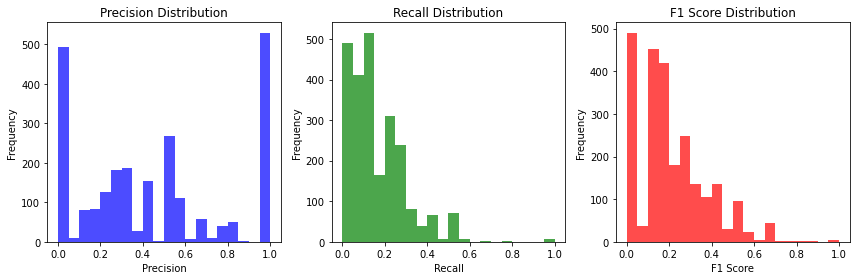

In [25]:
# Consolidated Metrics and Histograms
import matplotlib.pyplot as plt

# Extract metric scores from evaluation results (the 'results' list produced in your previous evaluation cell)
precision_scores = [r['precision'] for r in results]
recall_scores    = [r['recall'] for r in results]
f1_scores        = [r['f1'] for r in results]

# Print overall averages
avg_precision = sum(precision_scores) / len(precision_scores)
avg_recall    = sum(recall_scores) / len(recall_scores)
avg_f1        = sum(f1_scores) / len(f1_scores)

print(f"Average Precision: {avg_precision:.2f}")
print(f"Average Recall:    {avg_recall:.2f}")
print(f"Average F1 Score:  {avg_f1:.2f}")

# Plot distributions
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(precision_scores, bins=20, color='blue', alpha=0.7)
plt.title("Precision Distribution")
plt.xlabel("Precision")
plt.ylabel("Frequency")

plt.subplot(1,3,2)
plt.hist(recall_scores, bins=20, color='green', alpha=0.7)
plt.title("Recall Distribution")
plt.xlabel("Recall")
plt.ylabel("Frequency")

plt.subplot(1,3,3)
plt.hist(f1_scores, bins=20, color='red', alpha=0.7)
plt.title("F1 Score Distribution")
plt.xlabel("F1 Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [29]:
with open("f1_extremes_summary.txt", "w", encoding="utf-8") as f:
    f.write("=== Worst 3 Passages (by F1) ===\n")
    for r in sorted(results, key=lambda x: x['f1'])[:3]:
        f.write(f"\nPassage: {r['passage']}\n")
        f.write(f"GT: {r['ground_truth']}\n")
        f.write(f"Pred: {r['predicted_words']}\n")
        f.write(f"F1: {r['f1']:.2f}\n")

    f.write("\n=== Best 3 Passages (by F1) ===\n")
    for r in sorted(results, key=lambda x: x['f1'], reverse=True)[:3]:
        f.write(f"\nPassage: {r['passage']}\n")
        f.write(f"GT: {r['ground_truth']}\n")
        f.write(f"Pred: {r['predicted_words']}\n")
        f.write(f"F1: {r['f1']:.2f}\n")

print("Saved best/worst examples to f1_extremes_summary.txt ✅")

Saved best/worst examples to f1_extremes_summary.txt ✅


In [30]:
# Save Evaluation Results
import pandas as pd

eval_results_df = pd.DataFrame(results)
eval_results_df.to_csv("evaluation_results.csv", index=False)
# Add summary row to CSV
summary_row = {
    "passage": "AVERAGE",
    "predicted_words": "",
    "ground_truth": "",
    "precision": avg_precision,
    "recall": avg_recall,
    "f1": avg_f1,
    "raw_output": ""
}
eval_results_df = eval_results_df.append(summary_row, ignore_index=True)
eval_results_df.to_csv("evaluation_results.csv", index=False)
print("Saved evaluation with average row at bottom.")
print("Evaluation results have been saved to evaluation_results.csv")

Saved evaluation with average row at bottom.
Evaluation results have been saved to evaluation_results.csv


/tmp/ipykernel_98695/386772506.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eval_results_df = eval_results_df.append(summary_row, ignore_index=True)
